In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import radialProfile
import glob
import cv2
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
class DiskImageDataset():
    def __init__(self, img_paths, map_fn=None):
        self.img_paths = img_paths
        self.map_fn = map_fn
        
    def pil_loader(self, path):
        with open(path, 'rb') as f:
            return Image.open(f).convert('RGB')
        
    def __getitem__(self, i):
        if self.map_fn is not None:
            return self.map_fn(self.pil_loader(self.img_paths[i]))
        else:
            return self.pil_loader(self.img_paths[i])
    
    def __len__(self):
        return len(self.img_paths)

class shiftData(object):
    def __call__(self, img):
        img = np.asarray(img)
        img_copy = img.copy()

        h, w = img_copy.shape[:2]
        x = np.array(range(h))
        y = np.array(range(w))

        xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')

        index = []
        for i in zip(xv.flat, yv.flat):
            index.append((-1)**sum(i))
        index = np.array(index)
        index = index.reshape((h, w, -1))
        
        return (img*index)


class dataset_draw():
    def __init__(self, dataset, input_size):
        self.epsilon = 1e-8
        self.number_iter = 1000
        self.y = []
        self.error = []
        self.rgb_weights = [0.2989, 0.5870, 0.1140]
        self.dataset = dataset
        self.input_size = input_size
        self.N = {32:20, 64:43, 128:88}[self.input_size]
        if dataset == 'cifar10':
            self.real_data = DiskImageDataset(glob.glob('data/cifar10/cifar10' + str(self.input_size) + '/*.png'), map_fn=None)
            # self.shift_real_data = DiskImageDataset(glob.glob('data/cifar10/cifar10' + str(self.input_size) + '/*.png'), map_fn=shiftData())
        elif dataset == 'celeba':
            self.real_data = DiskImageDataset(glob.glob('data/celeba/celeba' + str(self.input_size) + '/*.png'), map_fn=None)
            # self.shift_real_data = DiskImageDataset(glob.glob('data/celeba/celeba' + str(self.input_size) + '/*.png'), map_fn=shiftData())
        elif dataset == 'lsun-church_outdoor':
            self.real_data = DiskImageDataset(glob.glob('data/lsun/church_outdoor' + str(self.input_size) + '/*.png'), map_fn=None)
            # self.shift_real_data = DiskImageDataset(glob.glob('data/lsun/church_outdoor' + str(self.input_size) + '/*.png'), map_fn=shiftData())
        elif dataset == 'CT_COVID':
            self.real_data = DiskImageDataset(glob.glob('data/CT_COVID/CT_COVID' + '/*.png'), map_fn=transforms.Resize((input_size, input_size)))
        elif dataset == 'VHR10':
            self.real_data = DiskImageDataset(glob.glob('data/VHR10/VHR10/positive image set' + '/*.jpg'), map_fn=transforms.Resize((input_size, input_size)))
        elif dataset == 'maps':
            self.real_data = DiskImageDataset(glob.glob('data/maps/maps64' + '/*.png'), map_fn=transforms.Resize((input_size, input_size)))
        elif dataset == 'chest_xray':
            self.real_data = DiskImageDataset(glob.glob('data/chest_xray/chest_xray64' + '/*.png'), map_fn=transforms.Resize((input_size, input_size)))

    def get_spectrum1D(self, data=None, folder=None):
        psd1D_total = np.zeros([self.number_iter, self.N])
        psd1D_org_mean = np.zeros(self.N)
        psd1D_org_std = np.zeros(self.N)

        phase1D_total = np.zeros([self.number_iter, self.N])
        phase1D_org_mean = np.zeros(self.N)
        phase1D_org_std = np.zeros(self.N)

        cont = 0
        if data is not None:
            for iter, x_ in enumerate(data):
                img = np.dot(np.asarray(x_), self.rgb_weights)
                f = np.fft.fft2(img)
                fshift = np.fft.fftshift(f)
                fshift += self.epsilon

                magnitude_spectrum = np.log(np.abs(fshift))
                phase_spectrum = np.angle(fshift)

                # Calculate the azimuthally averaged 1D power spectrum
                psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
                psd1D = (psd1D-np.min(psd1D))/(np.max(psd1D)-np.min(psd1D))
                psd1D_total[cont,:] = psd1D  

                phase1D = radialProfile.azimuthalAverage(phase_spectrum)
                phase1D = (phase1D-np.min(phase1D))/(np.max(phase1D)-np.min(phase1D))
                phase1D_total[cont,:] = phase1D 

                cont+=1
                
                if cont == self.number_iter:
                    break

        elif folder is not None:
            for filename in glob.glob(folder):
                img = cv2.resize(cv2.imread(filename, 0), (self.input_size, self.input_size))
                f = np.fft.fft2(img)
                fshift = np.fft.fftshift(f)
                fshift += self.epsilon

                magnitude_spectrum = np.log(np.abs(fshift))
                phase_spectrum = np.angle(fshift)

                # Calculate the azimuthally averaged 1D power spectrum
                psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
                psd1D = (psd1D-np.min(psd1D))/(np.max(psd1D)-np.min(psd1D))
                psd1D_total[cont,:] = psd1D  

                phase1D = radialProfile.azimuthalAverage(phase_spectrum)
                phase1D = (phase1D-np.min(phase1D))/(np.max(phase1D)-np.min(phase1D))
                phase1D_total[cont,:] = phase1D 

                cont+=1
                
                if cont == self.number_iter:
                    break

        for x in range(self.N):
            psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
            psd1D_org_std[x] = np.std(psd1D_total[:,x])

            phase1D_org_mean[x] = np.mean(phase1D_total[:,x])
            phase1D_org_std[x] = np.std(phase1D_total[:,x])

        return psd1D_org_mean, psd1D_org_std, phase1D_org_mean, phase1D_org_std


    def set_stat_main(self):
        # ----real data-------
        real_psd1D_mean, real_psd1D_std =  self.get_psd1D(data=self.real_data)
        # ----shift real data-------
        shift_real_psd1D_mean, shift_real_psd1D_std = self.get_psd1D(data=self.shift_real_data)
        # ----generated-------
        generated_psd1D_mean, generated_psd1D_std =  self.get_psd1D(folder="/data0/cly/spectralGan/GAN-collections/results/unshift/"
                                                                        + self.dataset + "/WGAN_GP_evaluate/*.png")
        # ----generated + SR-------
        generatedSR_psd1D_mean, generatedSR_psd1D_std =  self.get_psd1D(folder="/data0/cly/spectralGan/GAN-collections/results/unshift/"
                                                                        + self.dataset + "/WGAN_GP_SR_evaluate/*.png")
        # ----shift generated-------
        shift_generated_psd1D_mean, shift_generated_psd1D_std =  self.get_psd1D(folder="/data0/cly/spectralGan/GAN-collections/results/shift/"
                                                                        + self.dataset + "/WGAN_GP_evaluate/*.png")
        # ----shift generated + SR-------
        shift_generatedSR_psd1D_mean, shift_generatedSR_psd1D_std =  self.get_psd1D(folder="/data0/cly/spectralGan/GAN-collections/results/shift/"
                                                                        + self.dataset + "/WGAN_GP_SR_evaluate/*.png")

        self.y.append(real_psd1D_mean); self.error.append(real_psd1D_std)
        self.y.append(shift_real_psd1D_mean); self.error.append(shift_real_psd1D_std)
        self.y.append(generated_psd1D_mean); self.error.append(generated_psd1D_std)
        self.y.append(generatedSR_psd1D_mean); self.error.append(generatedSR_psd1D_std)
        self.y.append(shift_generated_psd1D_mean); self.error.append(shift_generated_psd1D_std)
        self.y.append(shift_generatedSR_psd1D_mean); self.error.append(shift_generatedSR_psd1D_std)

        self.label_list = ['real', 'shift-real', 'WGAN-GP', 'WGAN-GP-SR', 'sWGAN-GP', 'sWGAN-GP-SR']

    def set_stat_add(self, folder_list, label_list):
        # ----real data-------
        real_psd1D_mean, real_psd1D_std, real_phase1D_mean, real_phase1D_std = self.get_spectrum1D(data=self.real_data)
        # ----shift real data-------
        # shift_real_psd1D_mean, shift_real_psd1D_std = self.get_spectrum1D(data=self.shift_real_data)

        self.y.append(real_psd1D_mean); self.error.append(real_psd1D_std)
        self.y.append(real_phase1D_mean); self.error.append(real_phase1D_std)
        # self.y.append(shift_real_psd1D_mean); self.error.append(shift_real_psd1D_std)

        f_list = folder_list; self.label_list = ['真实图像振幅谱', '真实图像相位谱'] + label_list


        for f in f_list:
            psd1D_mean, psd1D_std, phase1D_mean, phase1D_std = self.get_spectrum1D(folder=f)
            self.y.append(psd1D_mean); self.error.append(psd1D_std)
            self.y.append(phase1D_mean); self.error.append(phase1D_std)


    def draw(self, legend=True, y_axis=True):  
        x = np.arange(0, self.N, 1)
        fig, ax = plt.subplots(figsize=(25, 15))
        
        for index, label in enumerate(self.label_list):
            if index%2 == 1:
                ax.plot(x, self.y[index], alpha=0.5, label=label, linewidth=8.0)
                # ax.fill_between(x, self.y[index] - self.error[index], self.y[index] + self.error[index], alpha=0.2)

        # plt.title('spectrum1D', fontsize=35)
        plt.xlabel('频率', fontsize=60)
        plt.ylabel('幅值', fontsize=60)
        plt.tick_params(axis='x', labelsize=40)
        plt.tick_params(axis='y', labelsize=40)
        plt.xlim((-1, 45))
        plt.ylim((-0.05, 1.1))
        ax.legend(loc='best', prop={'size': 45})
        fig.savefig('vae_A.pdf', dpi=800)
        
    # plt.style.use("seaborn-paper")
    

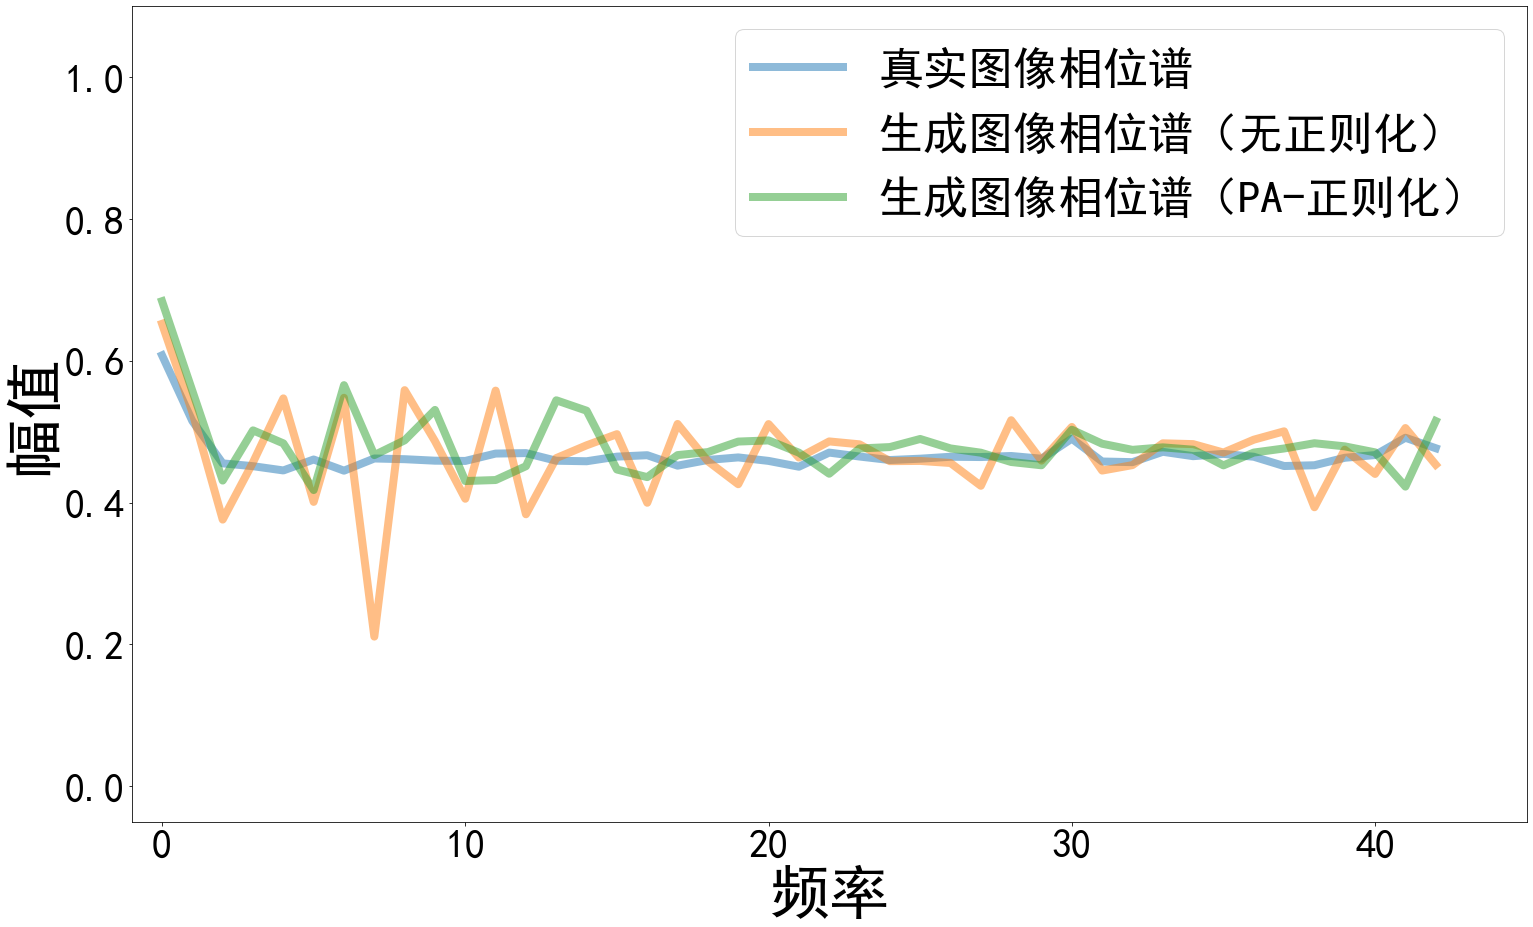

In [9]:
celeba_64x64 = dataset_draw('chest_xray', 64)
label_lsit = ['生成图像振幅谱（无正则化）', '生成图像相位谱（无正则化）', '生成图像振幅谱（PA-正则化）', '生成图像相位谱（PA-正则化）']
folder_list = ['/data0/cly/spectralGan/VAE/results_gen_deconv/*.png',
                '/data0/cly/spectralGan/VAE/results_gen_up1/*.png']
celeba_64x64.set_stat_add(folder_list, label_lsit)
celeba_64x64.draw()

In [ ]:
maps_64x64 = dataset_draw('maps', 64)
label_lsit = ['Vanilla_Amplitude1D', 'Vanilla_Phase1D', 'PA-Regularized_Amplitude1D', 'PA-Regularized_Phase1D']
folder_list = ['/data0/cly/spectralGan/VAE/results_gen_deconv/*.png',
                '/data0/cly/spectralGan/VAE/results_gen_up1/*.png']
maps_64x64.set_stat_add(folder_list, label_lsit)
maps_64x64.draw()

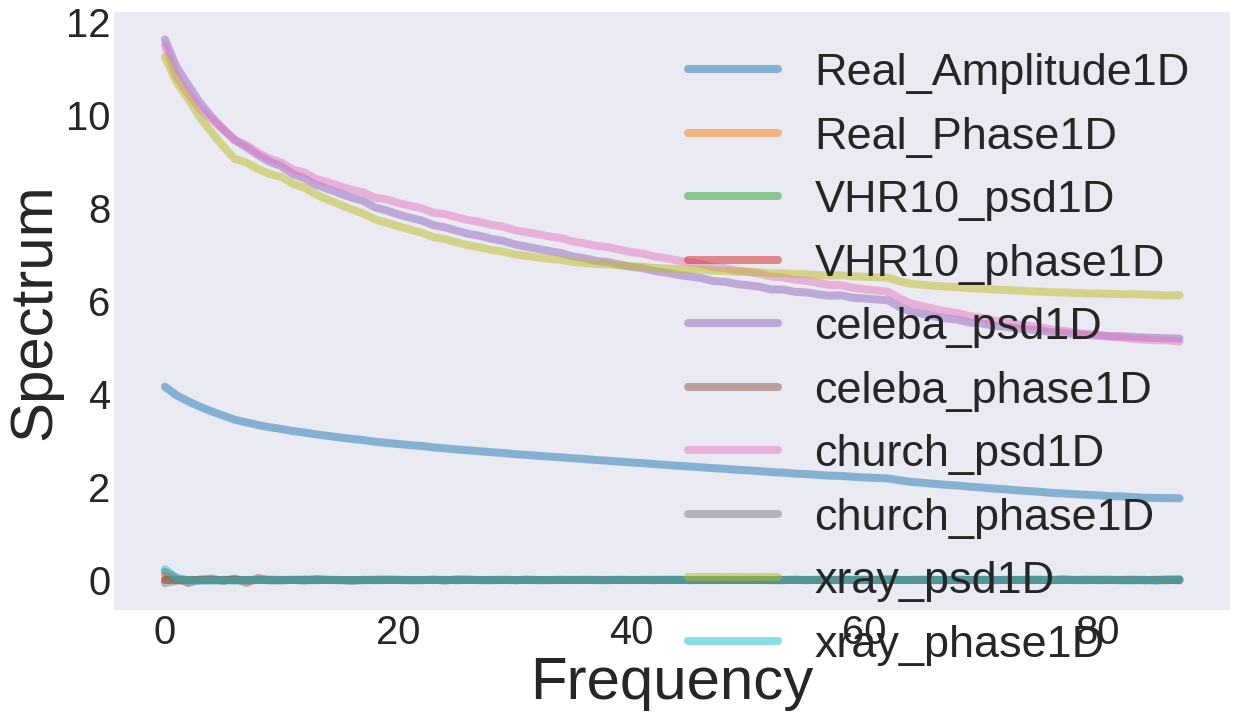

In [7]:
# plt.style.use("seaborn-dark")
ct_128x128 = dataset_draw('CT_COVID', 128)
label_lsit = ['VHR10_psd1D', 'VHR10_phase1D', 'celeba_psd1D', 'celeba_phase1D', 'church_psd1D', 'church_phase1D', 'xray_psd1D', 'xray_phase1D']
folder_list = ['/data0/cly/spectralGan/GAN-collections/data/VHR10/VHR10128/*png',
                '/data0/cly/spectralGan/GAN-collections/data/celeba/celeba128/*png',
                '/data0/cly/spectralGan/GAN-collections/data/lsun/church_outdoor128/*png',
                '/data0/cly/spectralGan/GAN-collections/data/chest_xray/chest_xray128/*png']
# folder_list = ['/data0/cly/spectralGan/GAN-collections/results_deconv/unshift/lsun-church_outdoor/WGAN_GP_128_100_evaluate/*.png',
#                 '/data0/cly/spectralGan/GAN-collections/results/unshift/lsun-church_outdoor/WGAN_GP_128_50_evaluate/*.png']
ct_128x128.set_stat_add(folder_list, label_lsit)
ct_128x128.draw()

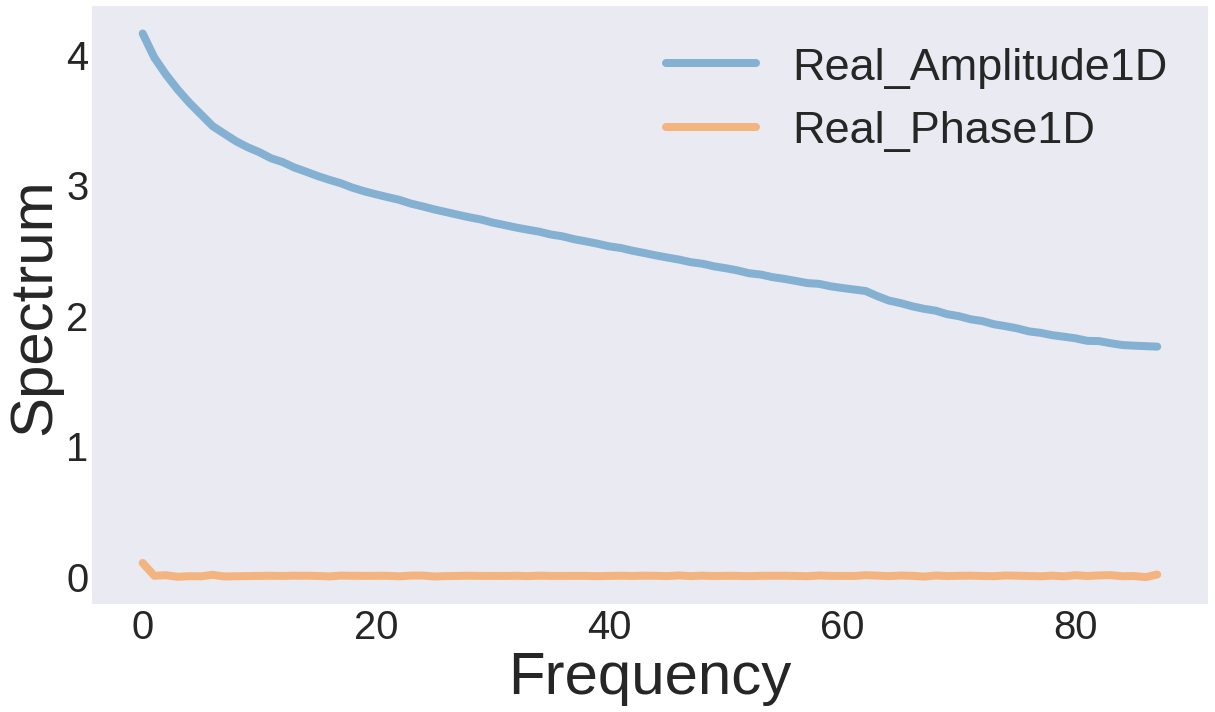

In [6]:
plt.style.use("seaborn-dark")
ct_128x128 = dataset_draw('CT_COVID', 128)
label_lsit = []
folder_list = []
# folder_list = ['/data0/cly/spectralGan/GAN-collections/results_deconv/unshift/lsun-church_outdoor/WGAN_GP_128_100_evaluate/*.png',
#                 '/data0/cly/spectralGan/GAN-collections/results/unshift/lsun-church_outdoor/WGAN_GP_128_50_evaluate/*.png']
ct_128x128.set_stat_add(folder_list, label_lsit)
ct_128x128.draw()


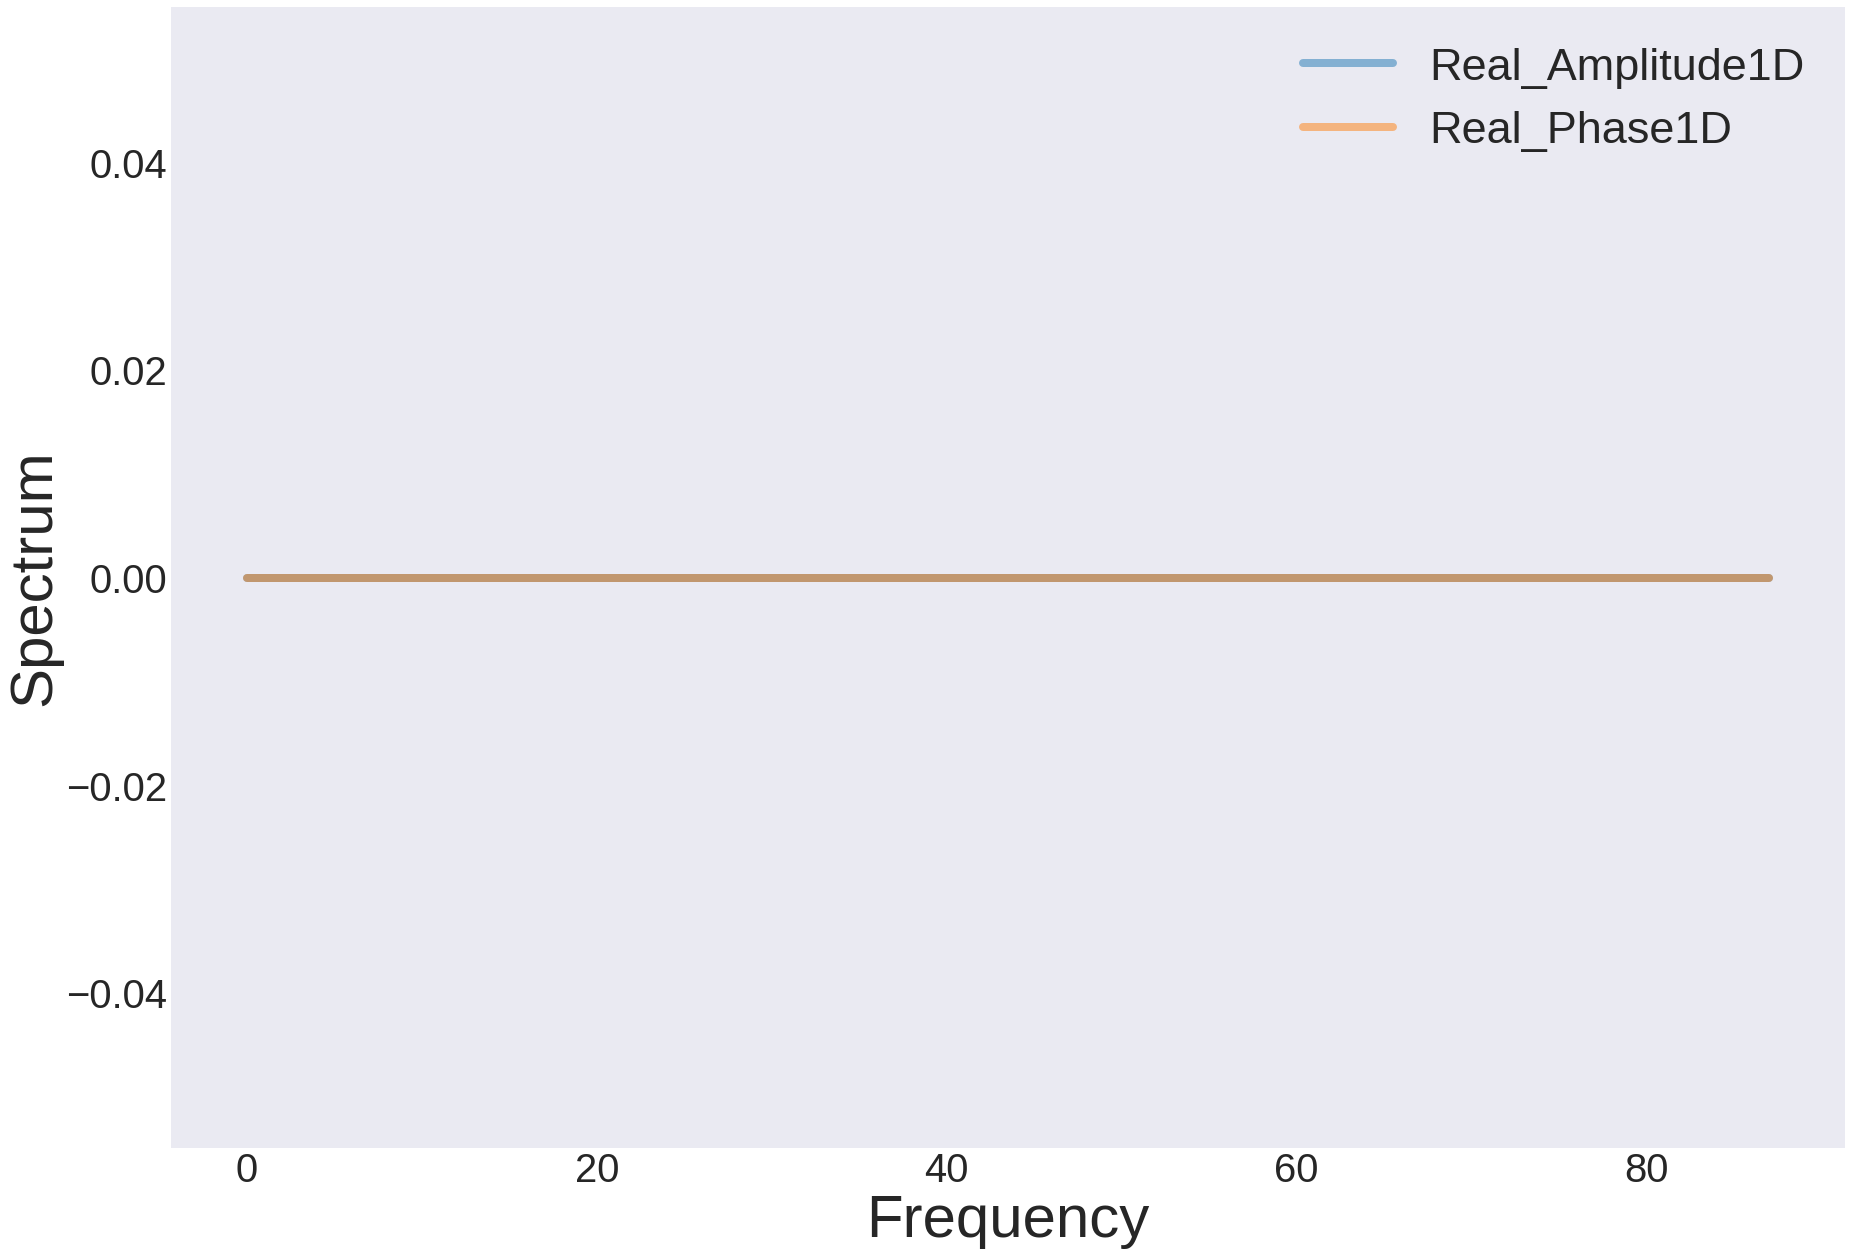

In [4]:
vhr_128x128 = dataset_draw('VHR10', 128)
label_lsit = []
folder_list = []
# folder_list = ['/data0/cly/spectralGan/GAN-collections/results_deconv/unshift/lsun-church_outdoor/WGAN_GP_128_100_evaluate/*.png',
#                 '/data0/cly/spectralGan/GAN-collections/results/unshift/lsun-church_outdoor/WGAN_GP_128_50_evaluate/*.png']
vhr_128x128.set_stat_add(folder_list, label_lsit)
vhr_128x128.draw()

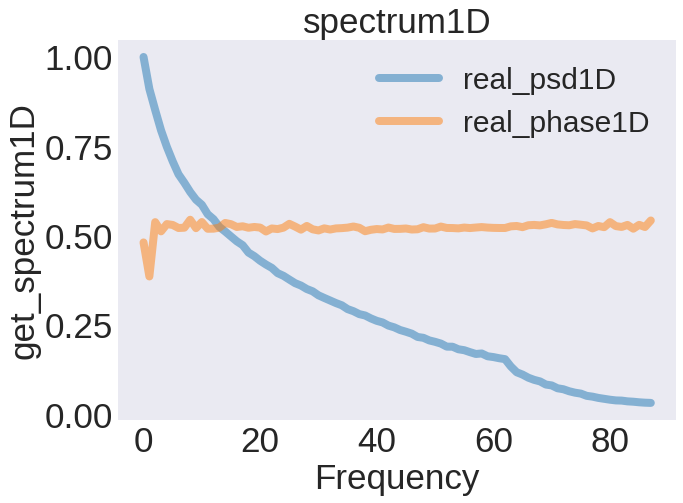

In [34]:
celeba_128x128 = dataset_draw('celeba', 128)
label_lsit = []
folder_list = []
# folder_list = ['/data0/cly/spectralGan/GAN-collections/results_deconv/unshift/lsun-church_outdoor/WGAN_GP_128_100_evaluate/*.png',
#                 '/data0/cly/spectralGan/GAN-collections/results/unshift/lsun-church_outdoor/WGAN_GP_128_50_evaluate/*.png']
celeba_128x128.set_stat_add(folder_list, label_lsit)
celeba_128x128.draw()

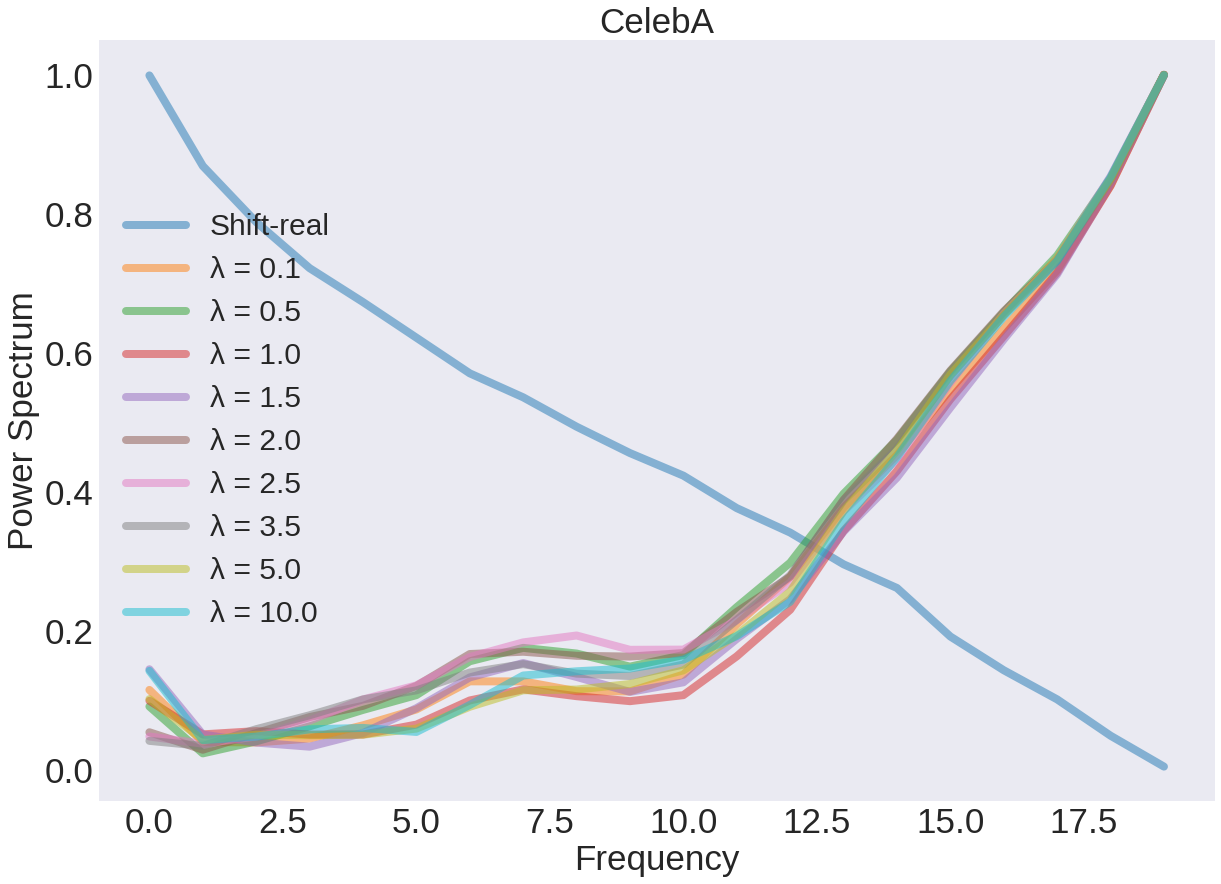

In [3]:
cifar10_32x32 = dataset_draw('cifar10', 32)
label_lsit = ['λ = 0.1','λ = 0.5', 'λ = 1.0', 'λ = 1.5', 'λ = 2.0', 'λ = 2.5', 'λ = 3.5',
                'λ = 5.0', 'λ = 10.0']
folder_list = ["/data0/cly/spectralGan/GAN-collections/results/para_tune/WGAN_GP_SR_0.1_evaluate/*.png",
        "/data0/cly/spectralGan/GAN-collections/results/para_tune/WGAN_GP_SR_0.5_evaluate/*.png",
        "/data0/cly/spectralGan/GAN-collections/results/para_tune/WGAN_GP_SR_1.0_evaluate/*.png",
        "/data0/cly/spectralGan/GAN-collections/results/para_tune/WGAN_GP_SR_1.5_evaluate/*.png",
        "/data0/cly/spectralGan/GAN-collections/results/para_tune/WGAN_GP_SR_2.0_evaluate/*.png",
        "/data0/cly/spectralGan/GAN-collections/results/para_tune/WGAN_GP_SR_2.5_evaluate/*.png",
        "/data0/cly/spectralGan/GAN-collections/results/para_tune/WGAN_GP_SR_3.5_evaluate/*.png",
        "/data0/cly/spectralGan/GAN-collections/results/para_tune/WGAN_GP_SR_5.0_evaluate/*.png",
        # "/data0/cly/spectralGan/GAN-collections/results/para_tune/WGAN_GP_SR_7.0_evaluate/*.png",
        "/data0/cly/spectralGan/GAN-collections/results/para_tune/WGAN_GP_SR_10.0_evaluate/*.png"]

        
cifar10_32x32.set_stat_add(folder_list, label_lsit)
cifar10_32x32.draw()

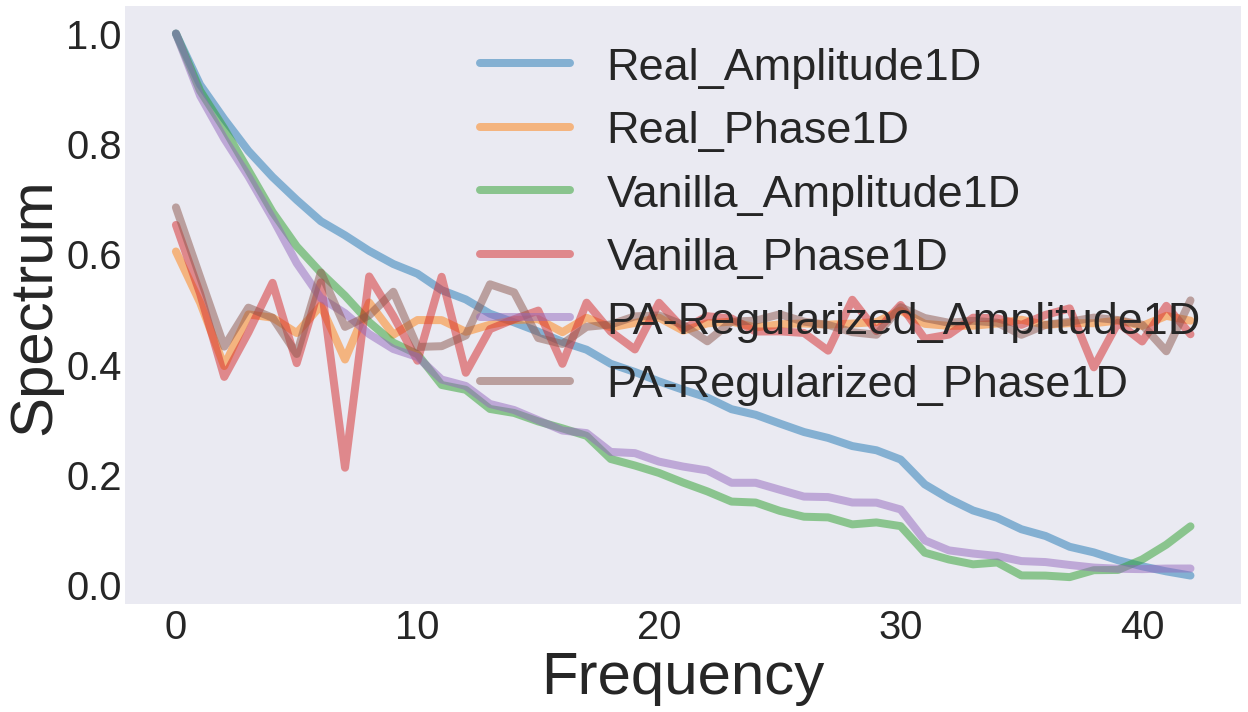

In [11]:
celeba_64x64 = dataset_draw('celeba', 64)
label_lsit = ['Vanilla_Amplitude1D', 'Vanilla_Phase1D', 'PA-Regularized_Amplitude1D', 'PA-Regularized_Phase1D']
folder_list = ['/data0/cly/spectralGan/VAE/results_gen_deconv/*.png',
                '/data0/cly/spectralGan/VAE/results_gen_up1/*.png']
celeba_64x64.set_stat_add(folder_list, label_lsit)
celeba_64x64.draw()

In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from scipy.interpolate import griddata
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import radialProfile, glob, cv2

filename = '/data0/cly/spectralGan/VAE/real.png'

img = cv2.imread(filename, 0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
fshift += 1e-8

magnitude_spectrum = 20*np.log(np.abs(fshift))

# Calculate the azimuthally averaged 1D power spectrum
psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
psd1D = (psd1D-np.min(psd1D))/(np.max(psd1D)-np.min(psd1D))

x = np.arange(0, 43, 1)
fig, ax = plt.subplots(figsize=(18, 12))


ax.plot(x, psd1D, alpha=0.5, label='VAE', linewidth=8.0)
# ax.fill_between(x, self.y[i] - self.error[i], self.y[i] + self.error[i], alpha=0.2)

plt.xlabel('Frequency', fontsize=35)
plt.ylabel('Power Spectrum', fontsize=35)
plt.tick_params(axis='x', labelsize=35)
plt.tick_params(axis='y', labelsize=35)

ax.legend(loc='best', prop={'size': 40})

IndexError: cannot do a non-empty take from an empty axes.

Files already downloaded and verified
Files already downloaded and verified


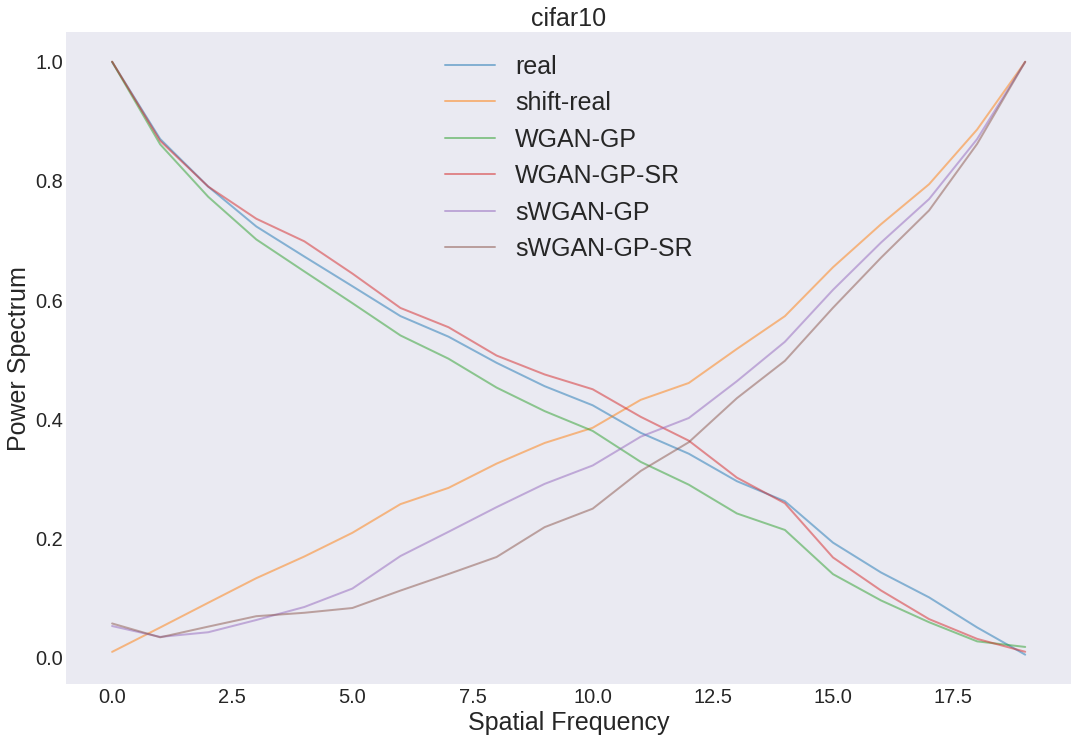

In [11]:
plt.style.use("seaborn-dark")
cifar10_32x32 = dataset_draw('cifar10', 32)
cifar10_32x32.draw('main')

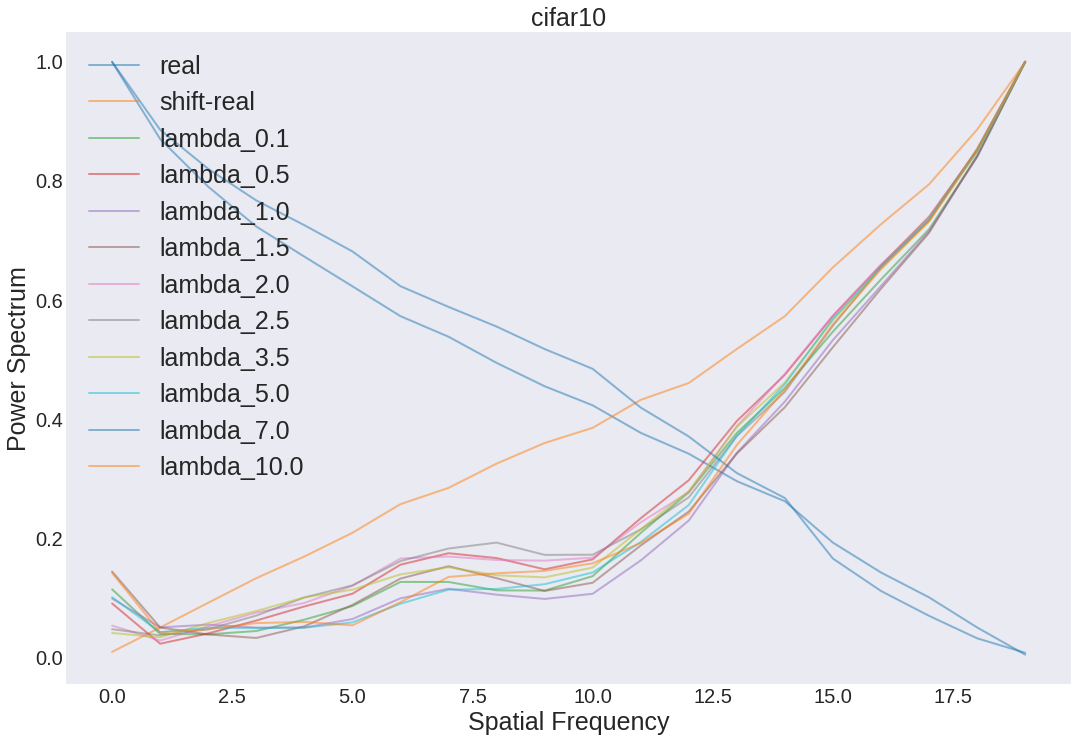

In [7]:
cifar10_32x32.draw('add')

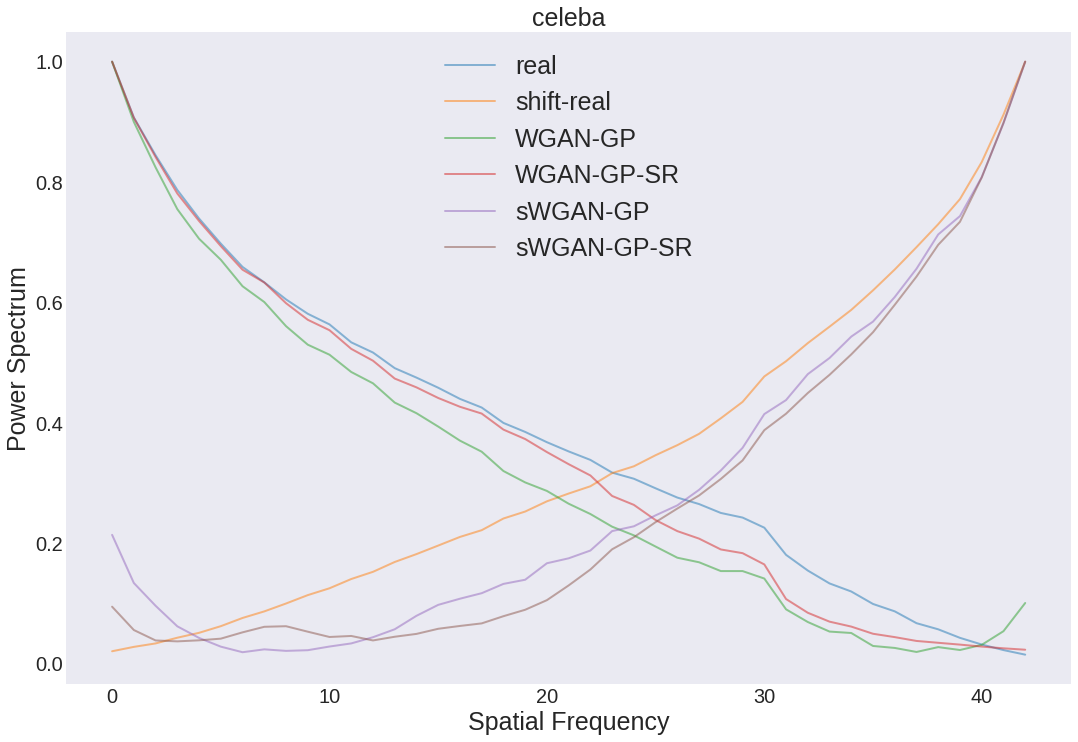

In [16]:
celeba_64x64 = dataset_draw('celeba', 64)
celeba_64x64.draw('main')

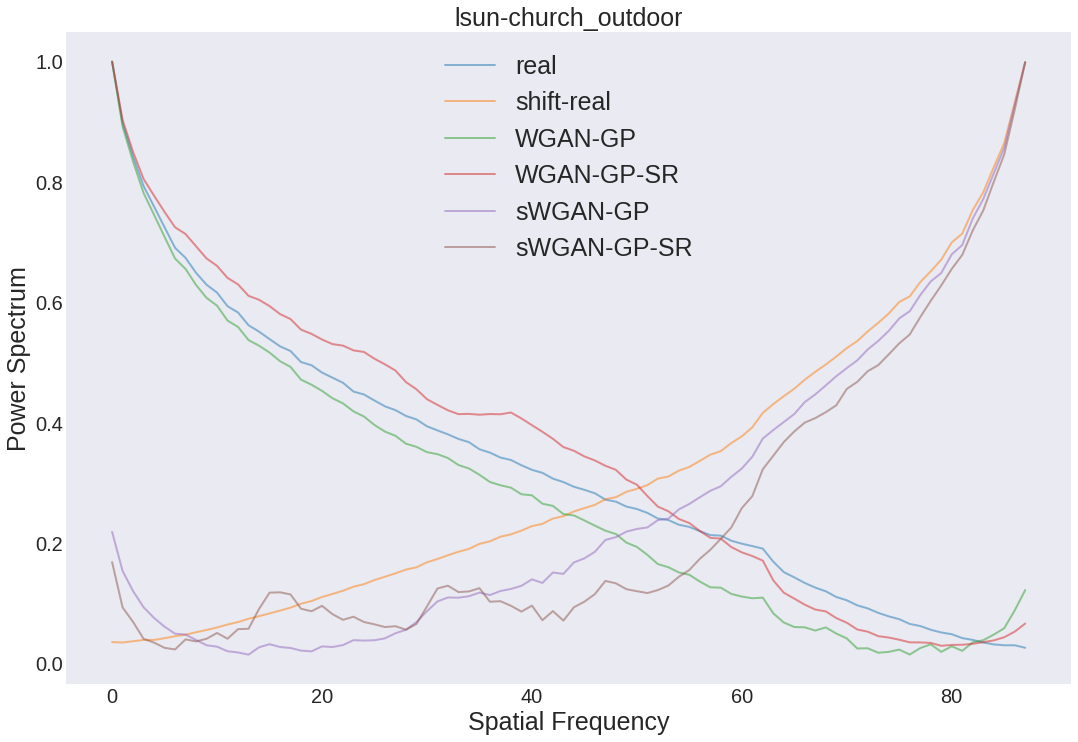

In [20]:
church_128x128 = dataset_draw('lsun-church_outdoor', 128)
church_128x128.draw('main')

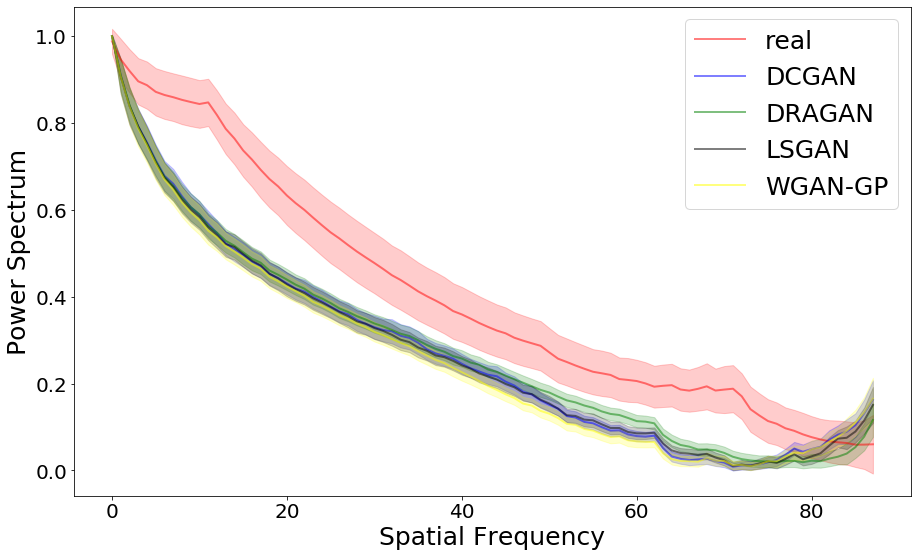